# Parameter Tuning in XGBoost
There are some official documents you can go through to better understand the parameters and codes:
* [XGBoost Parameters(offical guide)](http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)
* [Python API Reference (offical guide)](http://xgboost.readthedocs.io/en/latest/python/python_api.html)
* [XGBoost Demo Codes (xgboost GitHub repository)](https://github.com/dmlc/xgboost/tree/master/demo/guide-python)
* [Parameter Tuning in XGBoost (Analytics Vidhya)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
* [Learn More About the Machine Learning Algorithm(My website)](http://github.com/lddyato)

## Import Modules

In [93]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12, 7

In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Two forms of XGBoost**

* xgb – this is the direct xgboost library. I will use a specific function “cv” from this library
* XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM

Note that xgboost’s sklearn wrapper doesn’t have a “feature_importances” metric but a get_fscore() function which does the same job.

## Data

The data set is taken from Data Hackathon 3.x AV hackathon, same as that taken in the Ensemble Learning with Scikit-Learn. The details of the problem can be found on the <https://datahack.analyticsvidhya.com/contest/data-hackathon-3x/>.Due to the big size of the prepared data size, so the run time of the following algorithm takes more time.

In [3]:
train = pd.read_csv('train_Hackathon.csv')
test = pd.read_csv('test_Hackathon.csv')
test.drop('Disbursed', axis=1, inplace=True)

In [4]:
train.shape, test.shape

((87020, 51), (37717, 50))

In [5]:
train.dtypes[:10]

Disbursed                     float64
Existing_EMI                  float64
ID                             object
Loan_Amount_Applied           float64
Loan_Tenure_Applied           float64
Monthly_Income                  int64
Var4                            int64
Var5                            int64
Age                             int64
EMI_Loan_Submitted_Missing      int64
dtype: object

In [6]:
train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,39,1,...,0,0,0,0,1,1,0,1,0,0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,32,0,...,0,0,0,0,1,0,1,1,0,0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,36,1,...,0,0,0,0,0,0,1,0,0,1
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,30,1,...,0,0,0,0,0,0,1,0,0,1
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,33,1,...,0,0,0,0,0,0,1,0,0,1


In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in ['Disbursed', 'ID']]
len(predictors)

49

In [8]:
predictors[:10]

['Existing_EMI',
 'Loan_Amount_Applied',
 'Loan_Tenure_Applied',
 'Monthly_Income',
 'Var4',
 'Var5',
 'Age',
 'EMI_Loan_Submitted_Missing',
 'Interest_Rate_Missing',
 'Loan_Amount_Submitted_Missing']

In [11]:
X = train[predictors]
y = train['Disbursed']
X_test = test[predictors]
X.shape, X_test.shape

((87020, 49), (37717, 49))

In [10]:
y.value_counts() # imbalance class

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [96]:
test.columns

Index(['Existing_EMI', 'ID', 'Loan_Amount_Applied', 'Loan_Tenure_Applied',
       'Monthly_Income', 'Var4', 'Var5', 'Age', 'EMI_Loan_Submitted_Missing',
       'Interest_Rate_Missing', 'Loan_Amount_Submitted_Missing',
       'Loan_Tenure_Submitted_Missing', 'Processing_Fee_Missing',
       'Device_Type_0', 'Device_Type_1', 'Filled_Form_0', 'Filled_Form_1',
       'Gender_0', 'Gender_1', 'Var1_0', 'Var1_1', 'Var1_2', 'Var1_3',
       'Var1_4', 'Var1_5', 'Var1_6', 'Var1_7', 'Var1_8', 'Var1_9', 'Var1_10',
       'Var1_11', 'Var1_12', 'Var1_13', 'Var1_14', 'Var1_15', 'Var1_16',
       'Var1_17', 'Var1_18', 'Var2_0', 'Var2_1', 'Var2_2', 'Var2_3', 'Var2_4',
       'Var2_5', 'Var2_6', 'Mobile_Verified_0', 'Mobile_Verified_1',
       'Source_0', 'Source_1', 'Source_2'],
      dtype='object')

# Model Fit


Cross-validation with given parameters:

xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)


## Baseline Model

XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

In [12]:
xgtrain = xgb.DMatrix(X.values, label=y.values)
xgtest = xgb.DMatrix(X_test.values)

In [14]:
xgb0 = XGBClassifier()
print(xgb0.get_xgb_params()) # if don't use the print function, the results are printed in horizontal form

{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


In [17]:
xgb0_param = xgb0.get_xgb_params()
cv0 = xgb.cv(xgb0_param, xgtrain, num_boost_round=xgb0.get_params()['n_estimators'],nfold=5, 
             metrics='auc', early_stopping_rounds=50)

In [18]:
cv0.shape

(100, 4)

In [21]:
print(cv0.tail())

    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
95       0.835062      0.015264        0.852424       0.003025
96       0.835246      0.015304        0.852690       0.003003
97       0.835467      0.015372        0.852986       0.003018
98       0.835868      0.015325        0.853287       0.002992
99       0.836094      0.015106        0.853650       0.003074


In [27]:
# fit the algorithem on the data
xgb0.set_params(n_estimators=cv0.shape[0])
xgb0.fit(X, y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [23]:
# print the model score
xgb0.score(X,y)

0.98537117903930127

In [28]:
# predict on the training data
y_pred0 = xgb0.predict(X)
y_predprob0 = xgb0.predict_proba(X)[:,1] #Predict class probabilities for X. predict_proba返回的是一个两列的矩阵，矩阵的每一行代表的是对一个事件的预测结果，第一列代表该事件不会发生的概率，第二列代表的是该事件会发生的概率。而这里需要的是第二列的数据
accuracy_score(y.values, y_pred0), roc_auc_score(y, y_predprob0)

(0.98537117903930127, 0.85105818940795808)

In [29]:
# predict on the testing data, but i dont have the test['Disbursed'] data
X_test.columns

Index(['Existing_EMI', 'Loan_Amount_Applied', 'Loan_Tenure_Applied',
       'Monthly_Income', 'Var4', 'Var5', 'Age', 'EMI_Loan_Submitted_Missing',
       'Interest_Rate_Missing', 'Loan_Amount_Submitted_Missing',
       'Loan_Tenure_Submitted_Missing', 'Processing_Fee_Missing',
       'Device_Type_0', 'Device_Type_1', 'Filled_Form_0', 'Filled_Form_1',
       'Gender_0', 'Gender_1', 'Var1_0', 'Var1_1', 'Var1_2', 'Var1_3',
       'Var1_4', 'Var1_5', 'Var1_6', 'Var1_7', 'Var1_8', 'Var1_9', 'Var1_10',
       'Var1_11', 'Var1_12', 'Var1_13', 'Var1_14', 'Var1_15', 'Var1_16',
       'Var1_17', 'Var1_18', 'Var2_0', 'Var2_1', 'Var2_2', 'Var2_3', 'Var2_4',
       'Var2_5', 'Var2_6', 'Mobile_Verified_0', 'Mobile_Verified_1',
       'Source_0', 'Source_1', 'Source_2'],
      dtype='object')

## Parameter Tuning

The various steps to be performed are:

1. Choose a relatively **high learning rate**. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine **the optimum number of trees for this learning rate**. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. **Tune tree-specific parameters** ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
3. Tune **regularization parameters** (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
4. **Lower the learning rate** and decide the optimal parameters .

### Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:
1. max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
4. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
5. scale_pos_weight = 1: Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost.

In [31]:
xgb1 = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
                    subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', scale_pos_weight=1, seed=27)
xgb1_param=xgb1.get_xgb_params()
cv1 = xgb.cv(xgb1_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)
cv1.shape

(112, 4)

In [32]:
print(cv1.tail())

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
107       0.843866      0.013639        0.896949       0.002964
108       0.844019      0.013593        0.897561       0.002757
109       0.844056      0.013481        0.897946       0.002723
110       0.844289      0.013494        0.898501       0.003077
111       0.844590      0.013855        0.899015       0.003036


In [33]:
# fit the algorithem on the data
xgb1.set_params(n_estimators=cv1.shape[0])
xgb1.fit(X, y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=112, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [34]:
# predict on the training data
y_pred1 = xgb1.predict(X)
y_predprob1 = xgb1.predict_proba(X)[:,1] #Predict class probabilities for X. predict_proba返回的是一个两列的矩阵，矩阵的每一行代表的是对一个事件的预测结果，第一列代表该事件不会发生的概率，第二列代表的是该事件会发生的概率。而这里需要的是第二列的数据
xgb1.score(X,y), accuracy_score(y.values, y_pred1), roc_auc_score(y, y_predprob1)

(0.98539416226154908, 0.98539416226154908, 0.89168128665404356)

As you can see that here we got 112 as the optimal estimators for 0.1 learning rate. Note that this value might be too high for you depending on the power of your system. In that case you can increase the learning rate and re-run the command to get the reduced number of estimators.

### Tune max_depth and min_child_weight

In [38]:
param_test1 = {
 'max_depth':np.arange(3,10,2),
 'min_child_weight':np.arange(1,6,2)
}

In [39]:
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=112, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)
gsearch1.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=112, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_depth': array([3, 5, 7, 9]), 'min_child_weight': array([1, 3, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [44]:
gsearch1.best_params_, gsearch1.best_score_ # gsearch1.cv_results_, 

({'max_depth': 5, 'min_child_weight': 3}, 0.84043759313403665)

Here, we have run 12 combinations with wider intervals between values. The ideal values are 5 for max_depth and 3 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [45]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=112, max_depth=5,
                                                  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 6, 'min_child_weight': 4}, 0.84078281084749462)

In [48]:
gsearch1.grid_scores_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83547, std: 0.00982, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.83507, std: 0.01024, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.83552, std: 0.00893, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.84038, std: 0.00744, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.84044, std: 0.00656, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.83953, std: 0.00632, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.83900, std: 0.00614, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.83734, std: 0.00620, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.83670, std: 0.00471, params: {'max_depth': 7, 'min_child_weight': 5},
 mean: 0.83307, std: 0.00638, params: {'max_depth': 9, 'min_child_weight': 1},
 mean: 0.83287, std: 0.00497, params: {'max_depth': 9, 'min_child_weight': 3},
 mean: 0.83497, std: 0.00579, params: {'max_depth': 9, 'min_child_weight': 5}]

In [47]:
gsearch2.grid_scores_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83992, std: 0.00724, params: {'max_depth': 4, 'min_child_weight': 2},
 mean: 0.83993, std: 0.00769, params: {'max_depth': 4, 'min_child_weight': 3},
 mean: 0.83929, std: 0.00742, params: {'max_depth': 4, 'min_child_weight': 4},
 mean: 0.84053, std: 0.00556, params: {'max_depth': 5, 'min_child_weight': 2},
 mean: 0.84044, std: 0.00656, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.84051, std: 0.00587, params: {'max_depth': 5, 'min_child_weight': 4},
 mean: 0.84066, std: 0.00567, params: {'max_depth': 6, 'min_child_weight': 2},
 mean: 0.84014, std: 0.00594, params: {'max_depth': 6, 'min_child_weight': 3},
 mean: 0.84078, std: 0.00383, params: {'max_depth': 6, 'min_child_weight': 4}]

Here, we get the optimum values as 6 for max_depth and 4 for min_child_weight. Also, we can see the CV score increasing slightly. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance. 

In [49]:
param_test2b = {
 'min_child_weight':[4,6,8],
 'max_depth':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=112, max_depth=4,
                                                   min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                   objective= 'binary:logistic', scale_pos_weight=1,seed=27), 
                         param_grid = param_test2b, scoring='roc_auc', iid=False, cv=5)
gsearch2b.fit(X, y)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84078, std: 0.00383, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.83896, std: 0.00612, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.83969, std: 0.00506, params: {'max_depth': 6, 'min_child_weight': 8},
  mean: 0.83717, std: 0.00485, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.83580, std: 0.00631, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: 0.83507, std: 0.00626, params: {'max_depth': 8, 'min_child_weight': 8},
  mean: 0.83057, std: 0.00621, params: {'max_depth': 10, 'min_child_weight': 4},
  mean: 0.83125, std: 0.00827, params: {'max_depth': 10, 'min_child_weight': 6},
  mean: 0.83236, std: 0.00806, params: {'max_depth': 10, 'min_child_weight': 8},
  mean: 0.82501, std: 0.00913, params: {'max_depth': 12, 'min_child_weight': 4},
  mean: 0.82852, std: 0.00692, params: {'max_depth': 12, 'min_child_weight': 6},
  mean: 0.83009, std: 0.00715, params: {'max_depth': 12, 'min_child_weight': 8}],
 {'max_depth': 6, 'min_child_weig

We see 6 as the optimal value of the max_depth and 4 as the optimal value of the min_child_weight.

### Tune gamma

In [50]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=112, max_depth=6,
                                                  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=1,seed=27),
                        param_grid = param_test3, scoring='roc_auc', iid=False, cv=5)
gsearch3.fit(X,y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84078, std: 0.00383, params: {'gamma': 0.0},
  mean: 0.83907, std: 0.00626, params: {'gamma': 0.1},
  mean: 0.84102, std: 0.00527, params: {'gamma': 0.2},
  mean: 0.83970, std: 0.00600, params: {'gamma': 0.3},
  mean: 0.83906, std: 0.00708, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.84102050993369348)

This shows that our original value of gamma, i.e. 0.2 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

## The 2nd Model with update Parameters

In [51]:
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=6,
                     min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8, 
                     objective= 'binary:logistic', scale_pos_weight=1, seed=27)
xgb2_param=xgb2.get_xgb_params()
cv2 = xgb.cv(xgb2_param, xgtrain, num_boost_round=xgb2.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)
cv2.shape

(117, 4)

In [52]:
print(cv2.tail())

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
112       0.843894      0.015089        0.910176       0.001802
113       0.843897      0.014859        0.910683       0.001805
114       0.843859      0.014883        0.910941       0.001793
115       0.843899      0.014909        0.911232       0.001907
116       0.843962      0.015029        0.911671       0.001863


In [53]:
# fit the algorithem on the data
xgb2.set_params(n_estimators=cv2.shape[0])
xgb2.fit(X, y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=117, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [54]:
y_pred2 = xgb2.predict(X)
y_predprob2 = xgb2.predict_proba(X)[:,1]
xgb2.score(X, y), accuracy_score(y.values, y_pred2), roc_auc_score(y, y_predprob2)

(0.98540565387267298, 0.98540565387267298, 0.90663210045819687)

In [55]:
xgb1.score(X, y), accuracy_score(y.values, y_pred1), roc_auc_score(y, y_predprob1)

(0.98539416226154908, 0.98539416226154908, 0.89168128665404356)

In [56]:
xgb0.score(X, y), accuracy_score(y.values, y_pred0), roc_auc_score(y, y_predprob0)

(0.98537117903930127, 0.98537117903930127, 0.85105818940795808)

Here, we can see the improvement in score. So the final parameters are:
* n_estimators : 117
* max_depth: 6
* min_child_weight: 4
* gamma: 0.2

### Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [58]:
param_test4 = {
 'subsample':[i/10.0 for i in np.arange(6,10)],
 'colsample_bytree':[i/10.0 for i in np.arange(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=6,
                                                  min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=1, seed=27), 
                        param_grid = param_test4, scoring='roc_auc', iid=False, cv=5)
gsearch4.fit(X, y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83715, std: 0.00822, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.59999999999999998},
  mean: 0.83729, std: 0.00769, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.69999999999999996},
  mean: 0.83864, std: 0.00682, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.80000000000000004},
  mean: 0.83939, std: 0.00676, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.90000000000000002},
  mean: 0.83806, std: 0.00733, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.59999999999999998},
  mean: 0.83847, std: 0.00729, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.69999999999999996},
  mean: 0.83955, std: 0.00643, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.80000000000000004},
  mean: 0.83997, std: 0.00609, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.90000000000000002},
  mean: 0.83851, std: 0.00679, params: {'colsample_bytree': 0.8000000000

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [62]:
param_test5 = {
    'subsample':[i/100.0 for i in np.arange(75,90,5)],
    'colsample_bytree':[i/100.0 for i in np.arange(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=6,
                                                  min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=1, seed=27), 
                        param_grid = param_test5, scoring='roc_auc', iid=False, cv=5)
gsearch5.fit(X,y)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.80000000000000004, 'subsample': 0.80000000000000004},
 0.840788077457025)

Here, we can see the improvement in score. So the final parameters are:
* n_estimators : 117
* max_depth: 6
* min_child_weight: 4
* gamma: 0.2
* subsample: 0.8
* colsample_bytree: 0.8

### Tune Regularization Parameters

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [63]:
param_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=6,
                                                  min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=1, seed=27), 
                        param_grid = param_test6, scoring='roc_auc', iid=False, cv=5)
gsearch6.fit(X, y)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.84078798562374712)

We can see that the CV score is less than the previous case. But the values tried are very widespread, we should try values closer to the optimum here (1e-5) to see if we get something better.

In [64]:
param_test7 = {'reg_alpha':[0.0001, 0.0005, 0.00001, 0.00005]}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=6,
                                                  min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=1, seed=27), 
                        param_grid = param_test7, scoring='roc_auc', iid=False, cv=5)
gsearch7.fit(X, y)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0.0005}, 0.84083738172280387)

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact.

## The 3rd Model with updated Parameters

In [65]:
xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=6,
                     min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0005,
                     objective= 'binary:logistic', scale_pos_weight=1, seed=27)
xgb3_param=xgb3.get_xgb_params()
cv3 = xgb.cv(xgb3_param, xgtrain, num_boost_round=xgb3.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)
cv3.shape

(100, 4)

In [66]:
# fit the algorithem on the data
xgb3.set_params(n_estimators=cv3.shape[0])
xgb3.fit(X, y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0005, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [67]:
y_pred3 = xgb3.predict(X)
y_predprob3 = xgb3.predict_proba(X)[:,1]
xgb3.score(X, y), accuracy_score(y.values, y_pred3), roc_auc_score(y, y_predprob3)

(0.98539416226154908, 0.98539416226154908, 0.89963685986059705)

In [68]:
xgb2.score(X, y), accuracy_score(y.values, y_pred2), roc_auc_score(y, y_predprob2)

(0.98540565387267298, 0.98540565387267298, 0.90663210045819687)

In [69]:
xgb1.score(X, y), accuracy_score(y.values, y_pred1), roc_auc_score(y, y_predprob1)

(0.98539416226154908, 0.98539416226154908, 0.89168128665404356)

In [70]:
xgb0.score(X, y), accuracy_score(y.values, y_pred0), roc_auc_score(y, y_predprob0)

(0.98537117903930127, 0.98537117903930127, 0.85105818940795808)

## The 4th Model with Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [71]:
xgb4 = XGBClassifier(learning_rate =0.01, n_estimators=5000, max_depth=6,
                     min_child_weight=4, gamma=0.2, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0005,
                     objective= 'binary:logistic', scale_pos_weight=1, seed=27)
xgb4_param=xgb4.get_xgb_params()
cv4 = xgb.cv(xgb4_param, xgtrain, num_boost_round=xgb4.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)
cv4.shape

(1047, 4)

In [72]:
# fit the algorithem on the data
xgb4.set_params(n_estimators=cv4.shape[0])
xgb4.fit(X, y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=1047, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0005, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [73]:
y_pred4 = xgb4.predict(X)
y_predprob4 = xgb4.predict_proba(X)[:,1]
xgb4.score(X, y), accuracy_score(y.values, y_pred4), roc_auc_score(y, y_predprob4)

(0.98538267065042517, 0.98538267065042517, 0.90149057498304874)

In [75]:
print(xgb4.score(X, y),xgb3.score(X, y),xgb2.score(X, y),xgb1.score(X, y),xgb0.score(X, y))

0.98538267065 0.985394162262 0.985405653873 0.985394162262 0.985371179039


In [76]:
print(roc_auc_score(y, y_predprob4),roc_auc_score(y, y_predprob3),roc_auc_score(y, y_predprob2),roc_auc_score(y, y_predprob1),roc_auc_score(y, y_predprob0))

0.901490574983 0.899636859861 0.906632100458 0.891681286654 0.851058189408


Now we can see a significant boost in performance and the effect of parameter tuning is clearer.

## Feature Importance

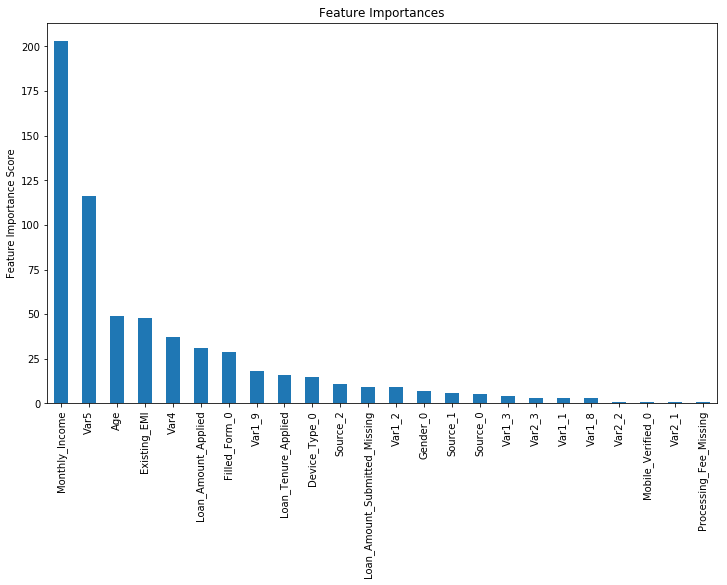

In [95]:
# Method 1: Plot importance based on fitted trees by using Matplotlib
feature_imp0 = pd.Series(xgb0.booster().get_fscore()).sort_values(ascending=False)
feature_imp0.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

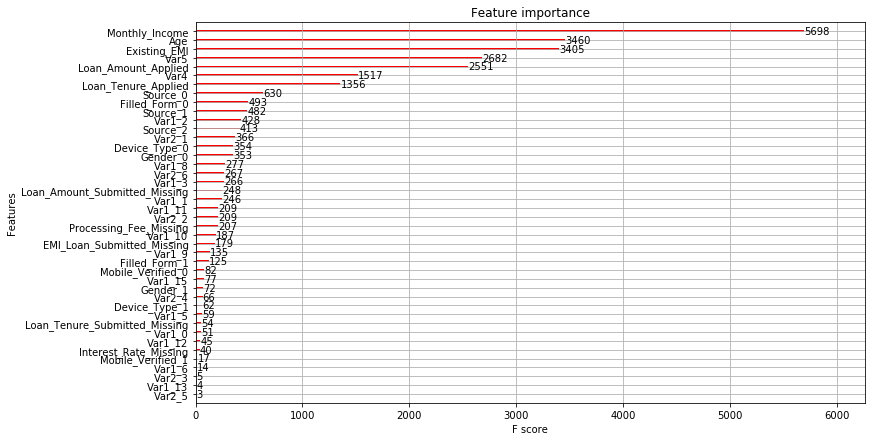

In [94]:
# Method 2
xgb.plot_importance(xgb4.booster(), color='red',grid=True,height=0.2)

## Summary

* It is difficult to get a very big leap in performance by just using parameter tuning or slightly better models. The max score for GBM was 0.8487 while XGBoost gave 0.8494. This is a decent improvement but not something very substantial.
* A significant jump can be obtained by other methods like feature engineering, creating ensemble of models, stacking, etc

## Define a function
After all processing, let's define a function which will help us create XGBoost models and perform cross-validation. 

In [98]:
# test_results = pd.read_csv('test_results.csv') 
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))
                
    xgb.plot_importance(alg.booster(), color='red') 